This notebooks takes a closer look at the wind data that corresponds to available data and publications.

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import cmocean as cmo
from datetime import datetime
%matplotlib inline

This notebook was derived from [Software Carpentry](https://douglatornell.github.io/2014-09-25-ubc/novice/python-eoas/index.html).

The historical data for Tuk Station is found at [Environment Canada](http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?searchType=stnName&timeframe=1&txtStationName=tuktoyaktuk&searchMethod=contains&optLimit=yearRange&StartYear=1840&EndYear=2017&Year=2017&Month=2&Day=28&selRowPerPage=25).

Information about wind direction is found in [Glossary](http://climate.weather.gc.ca/glossary_e.html#windDir).

The values are strings and are delimited by commas. If we skip the first 16 rows, we can ignore the rows that have station name, coordinates, elevation, and other details. Refer back to the link if you load temperature data as it accomodates the degree sign.

    Index(['Date/Time', 'Year', 'Month', 'Day', 'Time', 'Data Quality',
           'Temp (ÃÂ°C)', 'Temp Flag', 'Dew Point Temp (ÃÂ°C)',
           'Dew Point Temp Flag', 'Rel Hum (%)', 'Rel Hum Flag',
           'Wind Dir (10s deg)', 'Wind Dir Flag', 'Wind Spd (km/h)',
           'Wind Spd Flag', 'Visibility (km)', 'Visibility Flag',
           'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx', 'Hmdx Flag', 'Wind Chill',
           'Wind Chill Flag', 'Weather'],
          dtype='object')

In [2]:
def load_month(filename):
    path = '../data/for_atmospheric_forcing/'
    data = sep95 = pd.read_csv(path+filename, skiprows=16, encoding='ISO-8859-1')
    return data

In [3]:
sep95 = load_month('eng-hourly-09011995-09301995.csv')
oct95 = load_month('eng-hourly-10011995-10311995.csv')
nov95 = load_month('eng-hourly-11011995-11301995.csv')
dec95 = load_month('eng-hourly-12011995-12311995.csv')
sep02 = load_month('eng-hourly-09012002-09302002.csv')
oct02 = load_month('eng-hourly-10012002-10312002.csv')
aug74 = load_month('eng-hourly-08011974-08311974.csv')
aug75 = load_month('eng-hourly-08011975-08311975.csv')
sep86 = load_month('eng-hourly-09011986-09301986.csv')
mar87 = load_month('eng-hourly-03011987-03311987.csv')
apr87 = load_month('eng-hourly-04011987-04301987.csv')
may87 = load_month('eng-hourly-05011987-05311987.csv')
jun87 = load_month('eng-hourly-06011987-06301987.csv')
jul87 = load_month('eng-hourly-07011987-07311987.csv')
aug87 = load_month('eng-hourly-08011987-08311987.csv')
sep87 = load_month('eng-hourly-09011987-09301987.csv')
oct87 = load_month('eng-hourly-10011987-10311987.csv')
nov87 = load_month('eng-hourly-11011987-11301987.csv')

In [4]:
def convert_times(dates):
    times_all = []
    for ii in range(0, len(dates)):
        times_new = datetime.strptime(dates[ii], '%Y-%m-%d %H:%M')
        times_all.append(times_new)
    return times_all

def get_data_day(data, day):
    wind_speed = np.array(data['Wind Spd (km/h)'])
    wind_dir = np.array(data['Wind Dir (10s deg)']) #
    date_time = np.array(data['Date/Time'])
    day_index = np.where(data['Day']==day)   
    dates_day = convert_times(date_time[day_index])
    
    wind_speed_day = wind_speed[day_index] * 1000 / 3600
    wind_dir_day = wind_dir[day_index] * 10 #
    return dates_day, wind_speed_day, wind_dir_day

def get_data_range(data, days_start, days_end):
    n_hours = 24
    days_range = np.arange(days_start,days_end+1)
    wind_speed_range = np.zeros((len(days_range),n_hours))
    wind_dir_range = np.zeros_like(wind_speed_range) #
    dates_range = []
    for day, n in zip(days_range, np.arange(len(wind_speed_range))):
        dates_day, wind_speed_day, wind_dir_day = get_data_day(data, day) #
        wind_speed_range[n, :] = wind_speed_day
        wind_dir_range[n, :] = wind_dir_day #
        dates_range = np.append(dates_range, dates_day)
    wind_speed_range = wind_speed_range.flatten()
    wind_dir_range = wind_dir_range.flatten() #
    return dates_range, wind_speed_range, wind_dir_range

def convert_wind_stress(wind_speed_range):
    wind_stress_range = 1.25 * (1.5 * 10**-3) * (wind_speed_range**2)
    return wind_stress_range

def convert_angle_component(speed, angle):
    xcomp = -1 * speed * np.sin(np.deg2rad(angle))
    return xcomp

def combine_ranges(data_list, start_list, end_list):
    date_all = []
    speed_all = []
    stress_all = []

    for data, start, end in zip(data_list, start_list, end_list):
        dates, speed, direc = get_data_range(data, start, end) #
        stress = convert_wind_stress(speed)
        stress_x = convert_angle_component(stress, direc) #
        

        date_all = np.append(date_all, dates)
        speed_all = np.append(speed_all, speed)
        stress_all = np.append(stress_all, stress_x)
    
    return date_all, speed_all, stress_all

def plot_range(ax, dates, wind_stress, ymin = -0.3, ymax=0.3):
    ax.plot(dates, wind_stress, linewidth=1.5, color='royalblue')
    ax.set_ylabel('X Component of Wind Stress [Nm$^{-2}$]', fontsize=14)
    ax.yaxis.grid()
    ax.set_ylim([ymin, ymax])
    ax.axhline(0, c='k')
    return ax

def upwelling_event(ax, date_all, year, month, day, hr, label, inds, ev, y=0.2):
    if ev == 'upw':
        c = 'indianred'
    elif ev == 'wnd':
        c = 'indigo'
    elif ev == 'wnd2':
        c = 'orchid'
    elif ev == 'dta':
        c = 'darkgreen'
    else:
        c = 'k'
    ind = np.where(date_all == datetime(year, month, day, hr, 0))[0][0]
    ax.axvline(date_all[ind], color=c, linewidth=3.5)
    ax.text(date_all[ind-inds], y, label, rotation=90, fontsize=14)
    return ax

def wind_range(ax, date_all, year1, year2, month1, month2, day1, day2, label, ev):
    if ev == 'wnd':
        c = 'indigo'
    elif ev == 'wnd2':
        c = 'orchid'
    ind1 = np.where(date_all == datetime(year1, month1, day1, 0, 0))[0][0]
    ind2 = np.where(date_all == datetime(year2, month2, day2, 0, 0))[0][0]
    ax.hlines(y=0.25, xmin=date_all[ind1], xmax=date_all[ind2], color=c, linewidth=3.5)
    ax.text(date_all[ind1], 0.26, label, fontsize=14)
    return ax

def stress_max_min(ax, stress_all):
    max_stress = np.nanmax(stress_all)
    min_stress = np.nanmin(stress_all)
    ax.text(date_all[np.where(stress_all == max_stress)[0][0]], max_stress, str(np.round(max_stress,2)), fontsize=14)
    ax.text(date_all[np.where(stress_all == min_stress)[0][0]], min_stress, str(np.round(min_stress,2)), fontsize=14)
    return ax

# Carmack and Kulikov (1998)

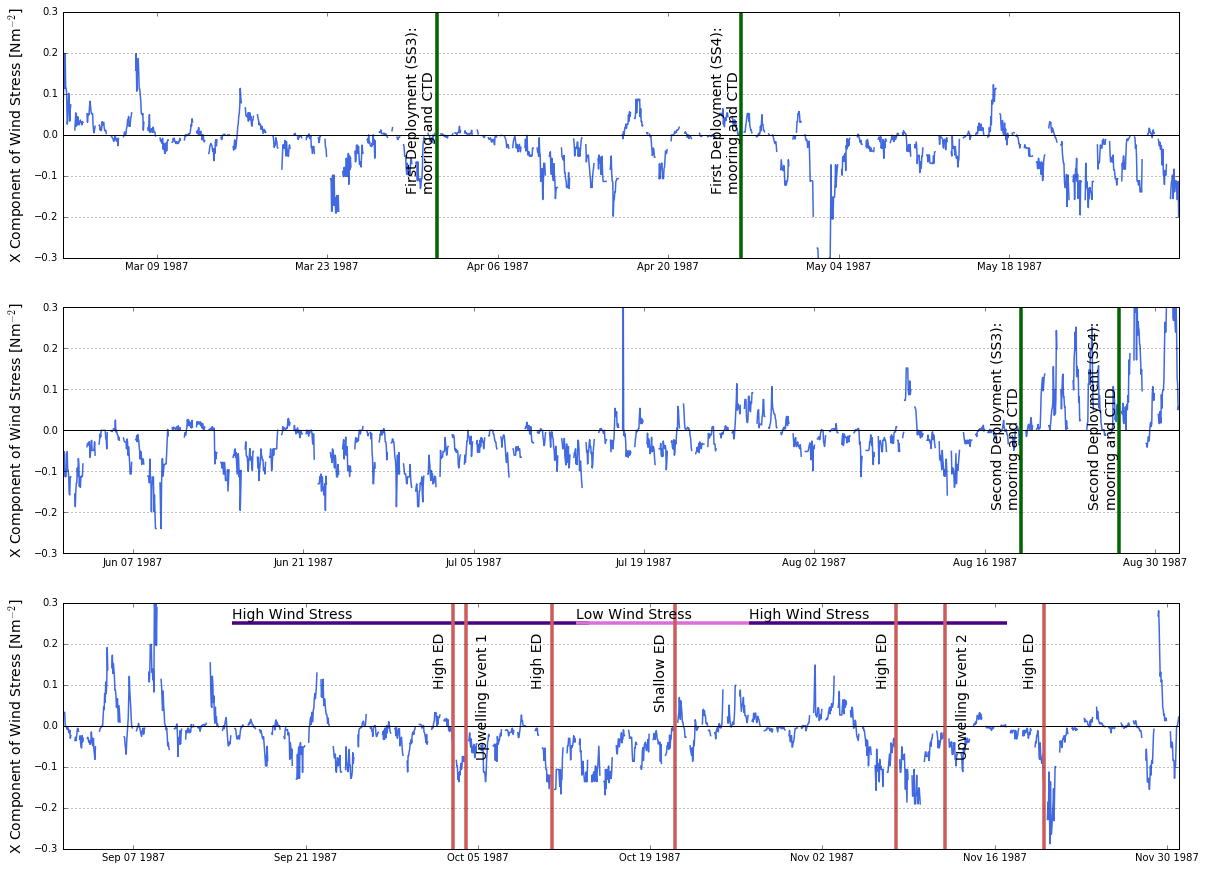

In [5]:
data_list = [mar87, apr87, may87]
start_list = [1,1,1]
end_list = [31,30,31]

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,15))

date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax1 = plot_range(ax1, date_all, stress_all)
ax1 = upwelling_event(ax1, date_all, 1987, 4, 1, 0,'First Deployment (SS3):\nmooring and CTD', 60, 'dta')
ax1 = upwelling_event(ax1, date_all, 1987, 4, 26, 0, 'First Deployment (SS4):\nmooring and CTD', 60, 'dta')

data_list = [jun87, jul87, aug87]
start_list = [1,1,1]
end_list = [30,31,31]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax2 = plot_range(ax2, date_all, stress_all)
ax2 = upwelling_event(ax2, date_all, 1987, 8, 19, 0, 'Second Deployment (SS3):\nmooring and CTD', 60, 'dta')
ax2 = upwelling_event(ax2, date_all, 1987, 8, 27, 0, 'Second Deployment (SS4):\nmooring and CTD', 60, 'dta')


data_list = [sep87, oct87, nov87]
start_list = [1,1,1]
end_list = [30,31,30]

date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax3 = plot_range(ax3, date_all, stress_all)
ax3 = upwelling_event(ax3, date_all, 1987, 10, 4, 0, 'Upwelling Event 1', -20, 'upw')
ax3 = upwelling_event(ax3, date_all, 1987, 11, 12, 0, 'Upwelling Event 2', -20, 'upw')
ax3 = upwelling_event(ax3, date_all, 1987, 10, 3, 0, 'High ED', 40, 'upw')
ax3 = upwelling_event(ax3, date_all, 1987, 10, 11, 0, 'High ED', 40, 'upw')
ax3 = upwelling_event(ax3, date_all, 1987, 11, 8, 0, 'High ED', 40, 'upw')
ax3 = upwelling_event(ax3, date_all, 1987, 11, 20, 0, 'High ED', 40, 'upw')
ax3 = upwelling_event(ax3, date_all, 1987, 10, 21, 0, 'Shallow ED', 40, 'upw')
ax3 = wind_range(ax3, date_all, 1987, 1987, 9, 10, 15, 14, 'High Wind Stress','wnd')
ax3 = wind_range(ax3, date_all, 1987, 1987, 10, 11, 27, 17, 'High Wind Stress','wnd')
ax3 = wind_range(ax3, date_all, 1987, 1987, 10, 10, 13, 27, 'Low Wind Stress','wnd2')

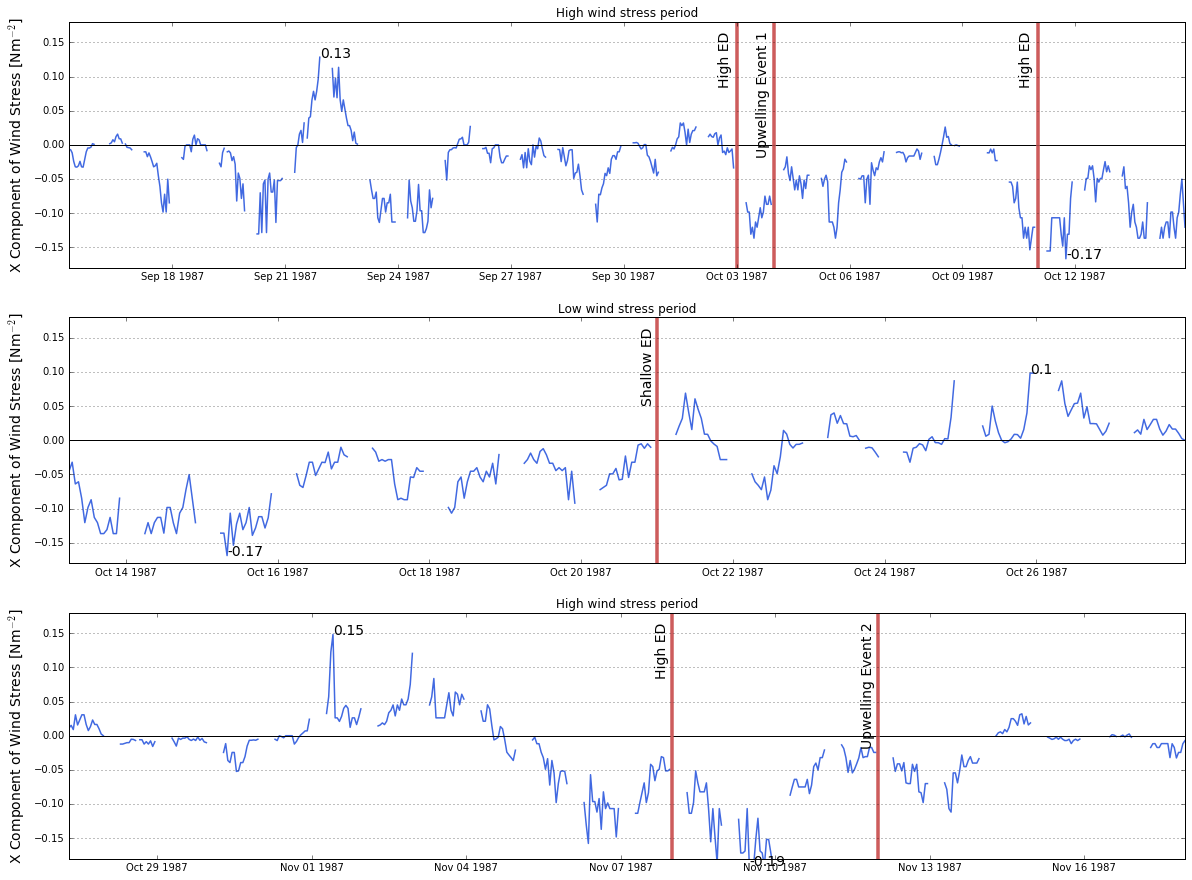

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,15))

data_list = [sep87, oct87]
start_list = [15,1]
end_list = [30,14]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax1 = plot_range(ax1, date_all, stress_all, -0.18, 0.18)
ax1 = stress_max_min(ax1, stress_all)
ax1 = upwelling_event(ax1, date_all, 1987, 10, 3, 0, 'High ED', 12, 'upw', 0.15)
ax1 = upwelling_event(ax1, date_all, 1987, 10, 4, 0, 'Upwelling Event 1', 12, 'upw', 0.15)
ax1 = upwelling_event(ax1, date_all, 1987, 10, 11, 0, 'High ED', 12, 'upw', 0.15)
ax1.set_title('High wind stress period')

data_list = [oct87]
start_list = [13]
end_list = [27]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax2 = plot_range(ax2, date_all, stress_all, -0.18, 0.18)
ax2 = stress_max_min(ax2, stress_all)
ax2 = upwelling_event(ax2, date_all, 1987, 10, 21, 0, 'Shallow ED', 5, 'upw', 0.15)
ax2.set_title('Low wind stress period')

data_list = [oct87, nov87]
start_list = [27,1]
end_list = [31,17]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax3 = plot_range(ax3, date_all, stress_all, -0.18, 0.18)
ax3 = stress_max_min(ax3, stress_all)
ax3 = upwelling_event(ax3, date_all, 1987, 11, 12, 0, 'Upwelling Event 2', 8, 'upw', 0.15)
ax3 = upwelling_event(ax3, date_all, 1987, 11, 8, 0, 'High ED', 8, 'upw', 0.15)
ax3.set_title('High wind stress period')

# Williams et al. (2006)

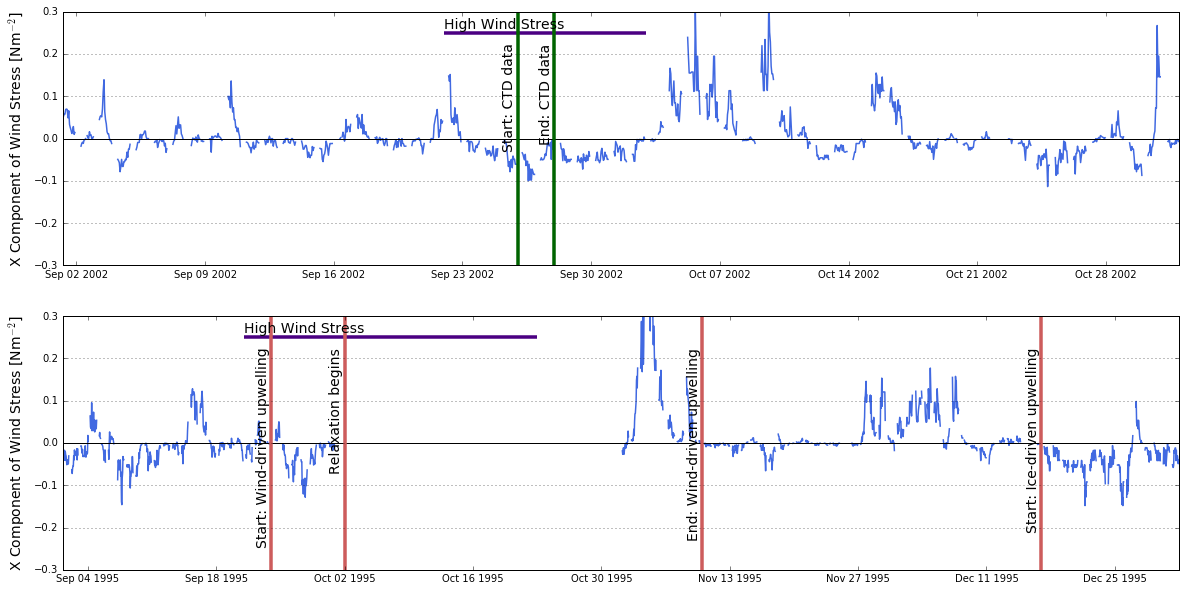

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,10))

data_list = [sep02, oct02]
start_list = [1,1]
end_list = [30,31]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax1 = plot_range(ax1, date_all, stress_all)
ax1 = wind_range(ax1, date_all, 2002, 2002, 9, 10, 22, 3, 'High Wind Stress','wnd')
ax1 = upwelling_event(ax1, date_all, 2002, 9, 26, 0, 'Start: CTD data', 20, 'dta')
ax1 = upwelling_event(ax1, date_all, 2002, 9, 28, 0, 'End: CTD data', 20, 'dta')

data_list = [sep95, oct95, nov95, dec95]
start_list = [1,1,1,1]
end_list = [30,30,30,31]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax2 = plot_range(ax2, date_all, stress_all)
ax2 = upwelling_event(ax2, date_all, 1995, 12, 17, 0, 'Start: Ice-driven upwelling', 40, 'upw')
ax2 = wind_range(ax2, date_all, 1995, 1995, 9, 10, 21, 23, 'High Wind Stress','wnd')
ax2 = upwelling_event(ax2, date_all, 1995, 9, 24, 0, 'Start: Wind-driven upwelling', 40, 'upw')
ax2 = upwelling_event(ax2, date_all, 1995, 11, 10, 0, 'End: Wind-driven upwelling', 40, 'upw')
ax2 = upwelling_event(ax2, date_all, 1995, 10, 2, 0, 'Relaxation begins', 40, 'upw')

# Other

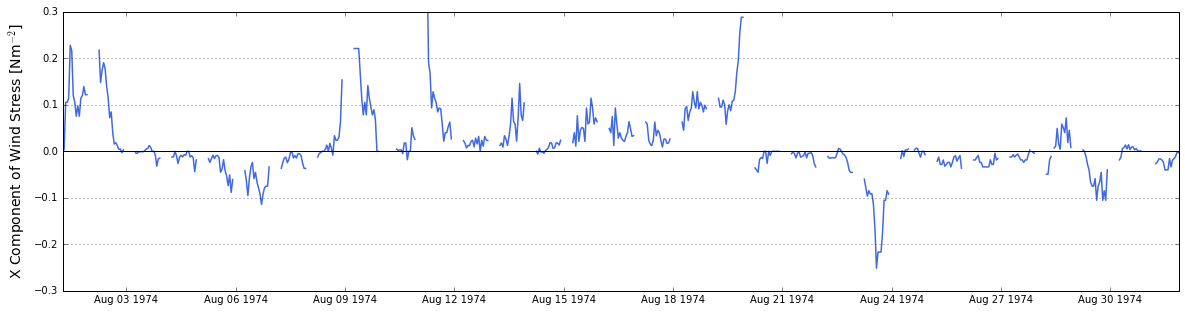

In [16]:
data_list = [aug74]
start_list = [1]
end_list = [31]

fig, ax = plt.subplots(1,1,figsize=(20,5))
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, stress_all)#, 'Macdonald et al. (1987)'

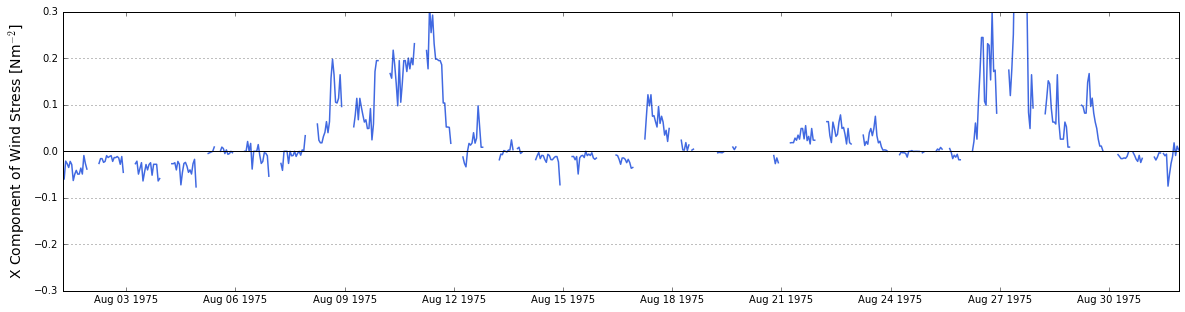

In [19]:
data_list = [aug75]
start_list = [1]
end_list = [31]

fig, ax = plt.subplots(1,1,figsize=(20,5))
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, stress_all) #, 'Macdonald et al. (1987)'

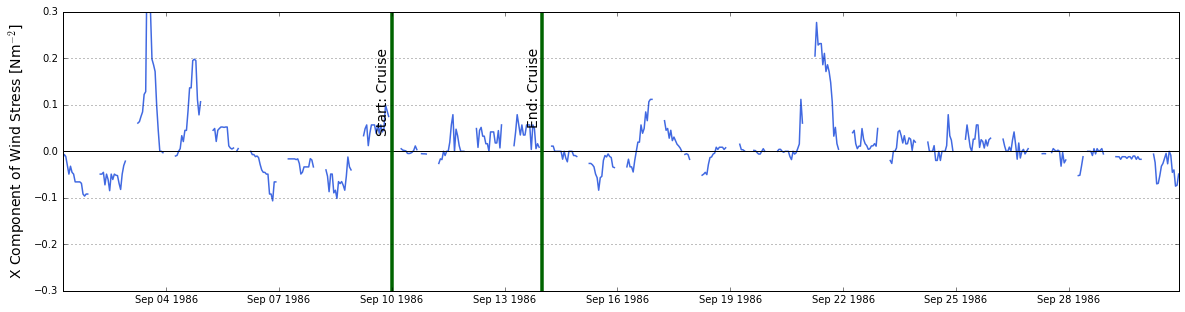

In [20]:
data_list = [sep86]
start_list = [1]
end_list = [30]

fig, ax = plt.subplots(1,1,figsize=(20,5))
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, stress_all) #, 'Macdonald et al. (1989) and Carmack et al. (1989)'
ax = upwelling_event(ax, date_all, 1986, 9, 10, 0, 'Start: Cruise', 10, 'dta')
ax = upwelling_event(ax, date_all, 1986, 9, 14, 0, 'End: Cruise', 10, 'dta')